# FLEX approximation
Author: [Kosuke Nogaki](mailto:kosuke.nogaki@yukawa.kyoto-u.ac.jp)

## Theory of FLEX in the paramagnetic state

## Code implementation

In [1]:
#using PyPlot
#rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
#rcParams["text.usetex"] = true
#rcParams["font.family"] = "serif"
#rcParams["font.size"] = 16
#rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using Plots
gr()
using LaTeXStrings

using Revise
using FFTW
using LinearAlgebra
using Roots
using SparseIR
import SparseIR: Statistics

# Check if a given function called with given types is type stable
function typestable(@nospecialize(f), @nospecialize(t))
    v = code_typed(f, t)
    stable = true
    for vi in v
        for (name, ty) in zip(vi[1].slotnames, vi[1].slottypes)
            !(ty isa Type) && continue
            if ty === Any
                stable = false
                println("Type instability is detected! the variable is $(name) ::$ty")
            end
        end
    end
    return stable
end

typestable (generic function with 1 method)

### Parameter setting

In [2]:
### System parameters
t    = 1      # hopping amplitude
W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W

T    = 0.1    # temperature
beta = 1/T    # inverse temperature
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4.0    # Hubbard interaction

### Numerical parameters
nk1, nk2  = 24, 24    # number of k_points along one repiprocal crystal lattice direction k1 = kx, k2 = ky
nk        = nk1*nk2
IR_tol    = 1e-10     # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
maxiter   = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_maxiter = 50       # maximal number of iteration steps in U renormalization loop
;

### Generating meshes

In [3]:
"""
Holding struct for k-mesh and sparsely sampled imaginary time 'tau' / Matsubara frequency 'iw_n' grids.
Additionally we defines the Fourier transform routines 'r <-> k'  and 'tau <-> l <-> wn'.
 """
struct Mesh
    nk1         ::Int64
    nk2         ::Int64
    nk          ::Int64
    ek          ::Array{Float64,2} 
    iw0_f       ::Int64
    iw0_b       ::Int64
    fnw         ::Int64
    fntau       ::Int64
    bnw         ::Int64
    bntau       ::Int64
    IR_basis_set::FiniteTempBasisSet
end

"""Initiarize function"""
function Mesh(
        nk1         ::Int64,
        nk2         ::Int64,
        IR_basis_set::FiniteTempBasisSet,
        )::Mesh
    
    nk::Int64 = nk1*nk2

    # Compute Hamiltonian
    ek = Array{ComplexF64,2}(undef, nk1, nk2)
    for iy in 1:nk2, ix in 1:nk1
        kx::Float64 = (2*π*(ix-1))/nk1
        ky::Float64 = (2*π*(iy-1))/nk2
        ek[ix, iy] = -2.0*(cos(kx)+cos(ky)) 
    end
    
    # lowest Matsubara frequency index
    iw0_f = findall(x->x==1,IR_basis_set.smpl_wn_f.sampling_points)[1]
    iw0_b = findall(x->x==0,IR_basis_set.smpl_wn_b.sampling_points)[1]
    
    # the number of sampling point for fermion and boson
    fnw   = length(IR_basis_set.smpl_wn_f.sampling_points)
    fntau = length(IR_basis_set.smpl_tau_f.sampling_points)
    bnw   = length(IR_basis_set.smpl_wn_b.sampling_points)
    bntau = length(IR_basis_set.smpl_tau_b.sampling_points)

    # Return
    Mesh(nk1, nk2, nk, ek, iw0_f, iw0_b, fnw, fntau, bnw, bntau, IR_basis_set)
end

function smpl_obj(mesh::Mesh, statistics::SparseIR.Statistics)
    """ Return sampling object for given statistic """
    if statistics == fermion
        smpl_tau = mesh.IR_basis_set.smpl_tau_f
        smpl_wn  = mesh.IR_basis_set.smpl_wn_f
    elseif statistics == boson
        smpl_tau = mesh.IR_basis_set.smpl_tau_b
        smpl_wn  = mesh.IR_basis_set.smpl_wn_b
    end    
    return smpl_tau, smpl_wn
end

"""Fourier transformation"""    
function tau_to_wn(mesh::Mesh, statistics, obj_tau) where {T <: SparseIR.Statistics}
    """ Fourier transform from tau to iw_n via IR basis """
    smpl_tau, smpl_wn = smpl_obj(mesh, statistics)

    obj_l = fit(smpl_tau, obj_tau, dim=1)
    obj_wn = evaluate(smpl_wn, obj_l, dim=1)
    return obj_wn
end

function wn_to_tau(mesh::Mesh, statistics::Statistics, obj_wn)
    """ Fourier transform from iw_n to tau via IR basis """
    smpl_tau, smpl_wn = smpl_obj(mesh, statistics)

    obj_l   = fit(smpl_wn, obj_wn, dim=1)
    obj_tau = evaluate(smpl_tau, obj_l, dim=1)
    return obj_tau
end
 
function k_to_r(mesh::Mesh, obj_k)
    """ Fourier transform from k-space to real space """
    obj_r = fft(obj_k,[2,3])
    return obj_r
end

function r_to_k(mesh::Mesh, obj_r)
    """ Fourier transform from real space to k-space """
    obj_k = ifft(obj_r,[2,3])/mesh.nk
    return obj_k
end

@assert typestable(tau_to_wn, (Mesh, SparseIR.Statistics, Array{ComplexF64,4}))
@assert typestable(wn_to_tau, (Mesh, SparseIR.Statistics, Array{ComplexF64,4}))

### FLEX loop solver

In [4]:
"""
Solver struct to calculate the FLEX loop self-consistently.
After initializing the Solver by `solver = FLEXSolver(mesh, beta, U, n, sigma_init, sfc_tol, maxiter, U_maxiter, mix)'
it can be run by `solve(solver)`.
 """
mutable struct FLEXSolver
    mesh     ::Mesh
    beta     ::Float64
    U        ::Float64
    n        ::Float64
    sfc_tol  ::Float64
    maxiter  ::Int64
    U_maxiter::Int64
    mix      ::Float64
    verbose  ::Bool
    mu       ::Float64
    gkio     ::Array{ComplexF64,3}
    grit     ::Array{ComplexF64,3}
    ckio     ::Array{ComplexF64,3}
    V        ::Array{ComplexF64,3}
    sigma    ::Array{ComplexF64,3}
end

"""Initiarize function"""
function FLEXSolver(
        mesh      ::Mesh,
        beta      ::Float64,
        U         ::Float64,
        n         ::Float64,
        sigma_init::Array{ComplexF64,3};
        sfc_tol   ::Float64=1e-4,
        maxiter   ::Int64  =100,
        U_maxiter ::Int64  =10,
        mix       ::Float64=0.2,
        verbose   ::Bool   =true
        )::FLEXSolver
    
        mu::Float64 = 0.0
    
        gkio  = Array{ComplexF64}(undef, mesh.fnw,   mesh.nk1, mesh.nk2)
        grit  = Array{ComplexF64}(undef, mesh.fntau, mesh.nk1, mesh.nk2)
        ckio  = Array{ComplexF64}(undef, mesh.bnw,   mesh.nk1, mesh.nk2)
        V     = Array{ComplexF64}(undef, mesh.bntau, mesh.nk1, mesh.nk2)
        sigma = sigma_init
    
        solver = FLEXSolver(mesh, beta, U, n, sfc_tol, maxiter, U_maxiter, mix, verbose, mu, gkio, grit, ckio, V, sigma)
    
        solver.mu = mu_calc(solver)
        gkio_calc(solver,solver.mu)
        grit_calc(solver)
        ckio_calc(solver)
        return solver
end

#%%%%%%%%%%% Loop solving instance
function solve(solver::FLEXSolver)
    """ FLEXSolver.solve() executes FLEX loop until convergence """
    # check whether U < U_crit! Otherwise, U needs to be renormalized.
    if maximum(abs, solver.ckio) * solver.U >= 1
        U_renormalization(solver)
    end
            
    # perform loop until convergence is reached:
    for it in 1:solver.maxiter
        sigma_old = copy(solver.sigma)
        loop(solver)
        
        # check whether solution is converged.
        sfc_check = sum(abs.(solver.sigma-sigma_old))/sum(abs.(solver.sigma))

        if solver.verbose
            println(it, '\t', sfc_check)
        end
        if sfc_check < solver.sfc_tol
            println("FLEX loop converged at desired accuracy")
            break
        end
    end
end
    
function loop(solver::FLEXSolver)
    """ FLEX loop """
    gkio_old = copy(solver.gkio)
    
    V_calc(solver)
    sigma_calc(solver)
        
    solver.mu = mu_calc(solver)
    gkio_calc(solver,solver.mu)
    
    solver.gkio .= solver.mix*solver.gkio .+ (1-solver.mix)*gkio_old
        
    grit_calc(solver)
    ckio_calc(solver)
end


#%%%%%%%%%%% U renormalization loop instance
function U_renormalization(solver::FLEXSolver)
    """ Loop for renormalizing U if Stoner enhancement U*max{chi0} >= 1. """
    println("WARNING: U is too large and the spin susceptibility denominator will diverge/turn unphysical!")
    println("Initiate U renormalization loop.")
    
    # save old U for later
    U_old::Float64 = solver.U
    # renormalization loop may run infinitely! Insert break condition after U_it_max steps
    U_it::Int64 = 0
    
    while U_old*maximum(abs, solver.ckio) >= 1.0
        U_it += 1
        
        # remormalize U such that U*chi0 < 1
        solver.U = solver.U / (maximum(abs, solver.ckio)*solver.U + 0.01)
        println(U_it, '\t', solver.U, '\t', U_old)
        
        # perform one shot FLEX loop
        loop(solver)
        
        # reset U
        solver.U = U_old
        
        # break condition for too many steps
        if U_it == solver.U_maxiter
            println("U renormalization reached breaking point")
            break
        end
    end
    println("Leaving U renormalization...")
end

#%%%%%%%%%%% Calculation steps
function gkio_calc(solver::FLEXSolver, mu::Float64)
    """ calculate Green function G(iw,k) """
    for iy in 1:solver.mesh.nk2, ix in 1:solver.mesh.nk1, iw in 1:solver.mesh.fnw
        iv::ComplexF64 = (im * π/solver.beta) * solver.mesh.IR_basis_set.smpl_wn_f.sampling_points[iw]
        solver.gkio[iw,ix,iy] = 1.0/(iv - solver.mesh.ek[ix, iy] + mu - solver.sigma[iw,ix,iy])
    end
end

function grit_calc(solver::FLEXSolver)
    """ Calculate real space Green function G(tau,r) [for calculating chi0 and sigma] """
    # Fourier transform
    grio = k_to_r(solver.mesh, solver.gkio)
    solver.grit .= wn_to_tau(solver.mesh, fermion, grio)
end

function ckio_calc(solver::FLEXSolver)
    """ Calculate irreducible susciptibility chi0(iv,q) """
    crit = Array{ComplexF64}(undef, solver.mesh.bntau, solver.mesh.nk1, solver.mesh.nk2)
    for iy in 1:solver.mesh.nk2, ix in 1:solver.mesh.nk1, it in 1:solver.mesh.bntau
        crit[it,ix,iy] = solver.grit[it,ix,iy] * solver.grit[solver.mesh.bntau-it+1,ix,iy]
    end

    # Fourier transform
    ckit = r_to_k(solver.mesh, crit)
    solver.ckio .= tau_to_wn(solver.mesh, boson, ckit)
end

function V_calc(solver::FLEXSolver)
    """ Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility for calculating sigma """
    # check whether U is too large and give warning
    if maximum(abs.(solver.ckio))*solver.U >= 1
        error("U*max(chi0) >= 1! Paramagnetic phase is left and calculations will turn unstable!")
    end
        
    # spin and charge susceptibility
    chi_spin   = solver.ckio ./ (1 .- solver.U .* solver.ckio)
    chi_charge = solver.ckio ./ (1 .+ solver.U .* solver.ckio)

    Vkio = (1.5*solver.U^2) .* chi_spin .+ (0.5*solver.U^2) .* chi_charge .- (solver.U^2) .* solver.ckio
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the single-band case, the Hartree term can be absorbed into the chemical potential.

    # Fourier transform
    Vrio = k_to_r(solver.mesh, Vkio)
    solver.V .= wn_to_tau(solver.mesh, boson, Vrio)
end

function sigma_calc(solver::FLEXSolver)
    """ Calculate self-energy Sigma(iw,k) """
    sigmarit = solver.V .* solver.grit
    
    # Fourier transform
    sigmakit = r_to_k(solver.mesh, sigmarit)
    solver.sigma .= tau_to_wn(solver.mesh, fermion, sigmakit)
end
    
    
#%%%%%%%%%%% Setting chemical potential mu
function calc_electron_density(solver::FLEXSolver,mu::Float64)::Float64
    """ Calculate electron density from Green function """
    gkio_calc(solver,mu)
    gio = dropdims(sum(solver.gkio,dims=(2,3)),dims=(2,3))/solver.mesh.nk
    
    g_l = fit(solver.mesh.IR_basis_set.smpl_wn_f,gio, dim=1)
    g_tau0 = dot(solver.mesh.IR_basis_set.basis_f.u(0), g_l)
    
    n  = 1.0 + real(g_tau0)
    n  = 2.0 * n #for spin
end

function mu_calc(solver::FLEXSolver)::Float64
    """ Find chemical potential for a given filling n0 via brent's root finding algorithm """
    f  = x -> calc_electron_density(solver,x) - solver.n
        
    mu = find_zero(f, (3*minimum(solver.mesh.ek), 3*maximum(solver.mesh.ek)), Roots.Brent()) 
end
@assert typestable(U_renormalization, FLEXSolver)
@assert typestable(solve, FLEXSolver)

### Execute FLEX loop

In [5]:
# initialize calculation
IR_basis_set = FiniteTempBasisSet(beta, Float64(wmax), IR_tol)
mesh = Mesh(nk1, nk2, IR_basis_set)
sigma_init = zeros(ComplexF64,(mesh.fnw, nk1, nk2))
solver = FLEXSolver(mesh, beta, U, n, sigma_init, sfc_tol=sfc_tol, maxiter=maxiter, U_maxiter=U_maxiter, mix=mix)

# perform FLEX loop
solve(solver)

Initiate U renormalization loop.
1	2.3679802693784353	4.0
2	2.6631530511909354	4.0
3	2.9528432020090873	4.0
4	3.23726650695482	4.0
5	3.5175353711274178	4.0
6	3.795074778959279	4.0
Leaving U renormalization...
1	0.08757050701835162
2	0.14458517806254953
3	0.022496516962767638
4	0.011826075022230582
5	0.007576749380833547
6	0.005298268436795435
7	0.0038627260880506878
8	0.002873781663752343
9	0.0021584597623247005
10	0.0016284507934079945
11	0.0012315292636750894
12	0.000933189033813289
13	0.0007086077737292493
14	0.0005394112523566285
15	0.0004118689361428679
16	0.0003156315340165748
17	0.00024290673625024201
18	0.0001878023867995447
19	0.00014592983406590043
20	0.00011401152358387733
21	8.956735422558271e-5
FLEX loop converged at desired accuracy


#### Visualize results

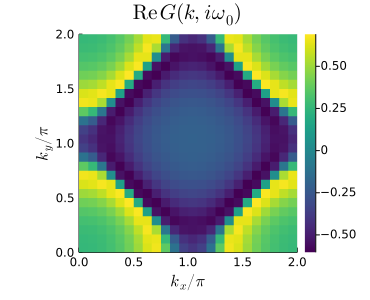

In [6]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. green function
myx = (2 .* collect(1:nk1) .- 1) ./ nk1
myy = (2 .* collect(1:nk1) .- 1) ./ nk2
heatmap(myx, myy, real.(solver.gkio[solver.mesh.iw0_f,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

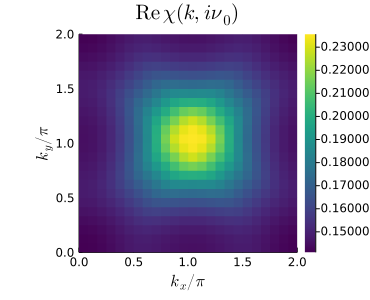

In [7]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
heatmap(myx, myy, real.(solver.ckio[solver.mesh.iw0_b,:,:]), 
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

## Linearized Eliashberg equation

### Code implementation

#### Linearized Eliashberg solver

In [8]:
"""
Solver struct for solving the linearized gap equation using the power method.
It takes FLEX results as an input.
"""
mutable struct LinearizedGapSolver
    mesh      ::Mesh
    gkio      ::Array{ComplexF64,3}
    V_singlet ::Array{ComplexF64,3}
    delta     ::Array{ComplexF64,3}
    frit      ::Array{ComplexF64,3}
    U         ::Float64
    maxiter   ::Int64
    sfc_tol   ::Float64
    verbose   ::Bool
    lam       ::Float64
end

function LinearizedGapSolver(
        FLEX_solver::FLEXSolver;
        maxiter    ::Int64  =50,
        sfc_tol    ::Float64=1e-4,
        verbose    ::Bool   =true
        )::LinearizedGapSolver
        
    ## Initialize necessary quantities from FLEX loop
    mesh       = FLEX_solver.mesh
    gkio       = FLEX_solver.gkio
    U          = FLEX_solver.U
        
    maxiter = maxiter
    sfc_tol = sfc_tol
    verbose = verbose
        
    ## Initialize trial gap function
    # Here we focus on a d-wave symmetric solution
    delta = Array{ComplexF64}(undef, FLEX_solver.mesh.fnw,   FLEX_solver.mesh.nk1, FLEX_solver.mesh.nk2)
    frit  = Array{ComplexF64}(undef, FLEX_solver.mesh.fntau, FLEX_solver.mesh.nk1, FLEX_solver.mesh.nk2)
    for iy in 1:FLEX_solver.mesh.nk2, ix in 1:FLEX_solver.mesh.nk1, iw in 1:FLEX_solver.mesh.fnw
        kx::Float64 = (2*π*(ix-1))/FLEX_solver.mesh.nk1
        ky::Float64 = (2*π*(iy-1))/FLEX_solver.mesh.nk2
        delta[iw,ix,iy] = cos(kx) - cos(ky) 
    end
    
    #normalize initial guess
    normalize!(delta)   
        
    # Initialize interaction
    V_singlet = V_singlet_calc(FLEX_solver)
        
    ## Initialize eigenvalue
    lam::Float64 = 0.0
    gap_solver = LinearizedGapSolver(mesh, gkio, V_singlet, delta, frit, U, maxiter, sfc_tol, verbose, lam)
end

function solve(gap_solver::LinearizedGapSolver)
    """ Solving instance to find eigenvalue from power method """
    for it in 1:gap_solver.maxiter
        lam_old = gap_solver.lam
        delta_old = copy(gap_solver.delta)
    
        frit_calc(gap_solver)
        deltarit = gap_solver.V_singlet .* gap_solver.frit
    
        # Fourier transform to momentum space
        deltakit = r_to_k(gap_solver.mesh, deltarit)
        gap_solver.delta .= tau_to_wn(gap_solver.mesh, fermion, deltakit)
    
        # calculate eigenvalue
        gap_solver.lam = sum(real.(conj.(gap_solver.delta).* delta_old))
        
        normalize!(gap_solver.delta) 
    
        if gap_solver.verbose
            println(it, '\t', gap_solver.lam, '\t', abs(gap_solver.lam-lam_old))
        end
        if abs(gap_solver.lam-lam_old) < gap_solver.sfc_tol
            break   
        end
    end
end

    
#%%%%%%%%%%% Calculation steps
function V_singlet_calc(solver::FLEXSolver)::Array{ComplexF64,3}
    """ Set up interaction in real space and imaginary time """
    chi_spin   = solver.ckio ./ (1 .- solver.U*solver.ckio)
    chi_charge = solver.ckio ./ (1 .+ solver.U*solver.ckio)
    
    Vkio = 1.5*solver.U^2 * chi_spin .- 0.5*solver.U^2 * chi_charge
    # Constant Hartree Term V ~ U needs to be treated extra, since they cannot be modeled by the IR basis.
    # In the special case of d-wave symmetry, it can be neglected.
    
    # Fourier transform
    Vrio = k_to_r(solver.mesh, Vkio)
    V_singlet = wn_to_tau(solver.mesh, boson, Vrio)
    return V_singlet
end

function frit_calc(gap_solver::LinearizedGapSolver)
    """ Calculate (linearized) anomalous Green function F = |G|^2 * delta for evaluating the gap equation """
    fkio = - gap_solver.gkio.*conj(gap_solver.gkio).*gap_solver.delta
        
    # Fourier transform
    frit = k_to_r(gap_solver.mesh, fkio)
    gap_solver.frit = wn_to_tau(gap_solver.mesh, fermion, frit)
end

frit_calc (generic function with 1 method)

#### Executing the gap equation solver

In [9]:
gap_solver = LinearizedGapSolver(solver, maxiter=maxiter, sfc_tol=sfc_tol)
solve(gap_solver)
println("The superconducting eigenvalue at T=",T," is lambda_d=",gap_solver.lam)

1	0.10885846909777899	0.10885846909777899
2	0.40584449241293263	0.29698602331515367
3	0.4494182491085552	0.04357375669562258
4	0.45617269033930136	0.006754441230746144
5	0.45777562430924573	0.0016029339699443756
6	0.45815514021379267	0.0003795159045469343
7	0.45825720409297005	0.00010206387917738313
8	0.45828371844140037	2.6514348430317636e-5
The superconducting eigenvalue at T=0.1 is lambda_d=0.45828371844140037


#### Visualize results

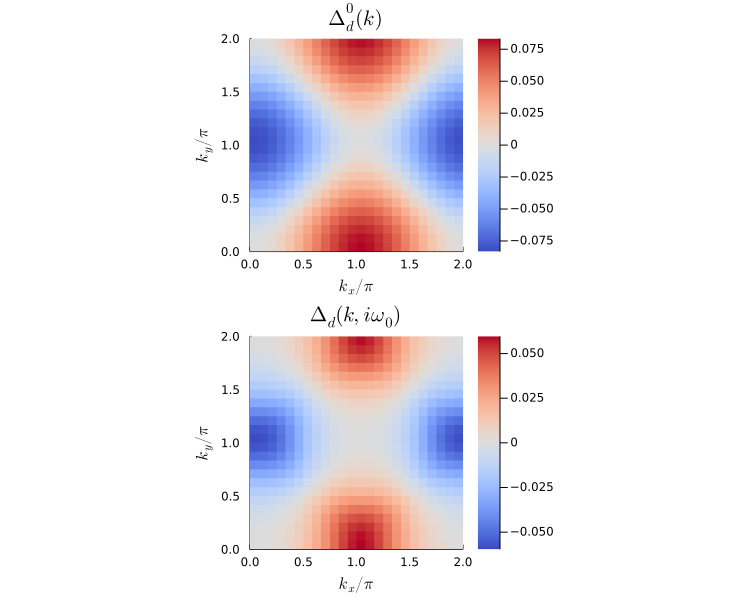

In [10]:
# plot 2D k-dependence of lowest Matsubara frequency of the gap vs. initial guess
delta0 = Array{ComplexF64}(undef, gap_solver.mesh.nk1, gap_solver.mesh.nk2)
for iy in 1:gap_solver.mesh.nk2, ix in 1:gap_solver.mesh.nk1
    kx::Float64 = (2*π*(ix-1))/nk1
    ky::Float64 = (2*π*(iy-1))/nk2
    delta0[ix,iy] = cos(kx) - cos(ky) 
end
normalize!(delta0)

plt1 = heatmap(myx, myy, real.(delta0[:,:]), 
    title=latexstring("\\Delta^0_d (k)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:coolwarm, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

plt2 = heatmap(myx, myy, real.(gap_solver.delta[gap_solver.mesh.iw0_f,:,:]), 
    title=latexstring("\\Delta_d (k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:coolwarm, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

plot(plt1, plt2, layout = (2,1), size=(740, 600))

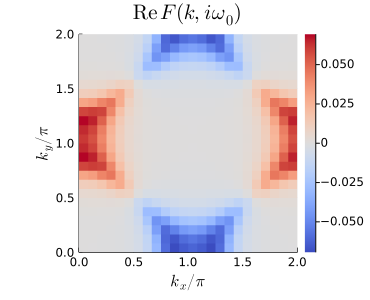

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of the anomalous Green function
fkio = - gap_solver.gkio.*conj(gap_solver.gkio).*gap_solver.delta
heatmap(myx, myy, real.(fkio[gap_solver.mesh.iw0_f,:,:]), 
    title=latexstring("\\mathrm{Re}\\,F (k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:coolwarm, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

## Example: Antiferromagnetic fluctuations and $d$-wave superconductivity in the square-lattice Hubbard model

In [12]:
#%%%%%%%%%%%%%%% Parameter settings
println("Initialization...")
# system parameters
t    = 1      # hopping amplitude
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4.0    # Hubbard interaction

W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W
T_values = [0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.025]# temperature

# numerical parameters
nk1, nk2  = 64, 64    # k-mesh sufficiently dense!
nk        = nk1*nk2
IR_Lambda = 10^3      # dimensionless IR parameter >= w_max * beta_min = 400
IR_tol    = 1e-7      # accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # accuracy for self-consistent iteration
it_max    = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_it_max  = 50        # maximal number of iteration steps in U renormalization loop

# initialize first IR basis set (no recalculation afterwrds)
beta_init = 1.0/T_values[1]
IR_basis_set = FiniteTempBasisSet(beta_init, IR_Lambda/beta_init, IR_tol)

# set initial self_energy - will be set to previous calculation step afterwards
sigma_init = zeros(ComplexF64,(length(IR_basis_set.smpl_wn_f.sampling_points), nk1, nk2))

# empty arrays for results
lam_T     = Array{Float64}(undef,length(T_values))
chiSmax_T = Array{Float64}(undef,length(T_values))
chi_s_plt = Array{Float64}(undef,nk1,nk2)

#%%%%%%%%%%%%%%% Calculations for different T values
for T_it in 1:length(T_values)
    T = T_values[T_it]
    println("Now: T = ", T)
    beta = 1/T

    # initialize meshes
    IR_basis_set = FiniteTempBasisSet(beta, IR_Lambda/beta, IR_tol, sve_result=IR_basis_set.basis_f.sve_result)
    mesh = Mesh(nk1, nk2, IR_basis_set)
    
    # calculate FLEX loop
    solver = FLEXSolver(mesh, beta, U, n, sigma_init, sfc_tol=sfc_tol, maxiter=it_max, U_maxiter=U_it_max, mix=mix, verbose=false)
    solve(solver)
    
    sigma_init = copy(solver.sigma)
    
    # calculate linearized gap equation
    gap_solver = LinearizedGapSolver(solver, maxiter=it_max, sfc_tol=sfc_tol, verbose=false)
    solve(gap_solver)
    
    # save data for plotting
    lam_T[T_it] = gap_solver.lam
    chi_spin   = solver.ckio ./ (1 .- solver.U*solver.ckio)
    chiSmax_T[T_it] = real(findmax(abs.(chi_spin))[1])
    
    if T == 0.03
        chi_s_plt .= real.(chi_spin[solver.mesh.iw0_b,:,:])
    end

end

Initialization...
Now: T = 0.08
Initiate U renormalization loop.
1	2.2871468486829434	4.0
2	2.485684779143936	4.0
3	2.689078072220692	4.0
4	2.8952476521632686	4.0
5	3.1004196145564937	4.0
6	3.3068380776791946	4.0
7	3.5156371202927716	4.0
8	3.7272845417142584	4.0
9	3.9417174846073464	4.0
Leaving U renormalization...
FLEX loop converged at desired accuracy
Now: T = 0.07
FLEX loop converged at desired accuracy
Now: T = 0.06
FLEX loop converged at desired accuracy
Now: T = 0.05
FLEX loop converged at desired accuracy
Now: T = 0.04
FLEX loop converged at desired accuracy
Now: T = 0.03
FLEX loop converged at desired accuracy
Now: T = 0.025
FLEX loop converged at desired accuracy


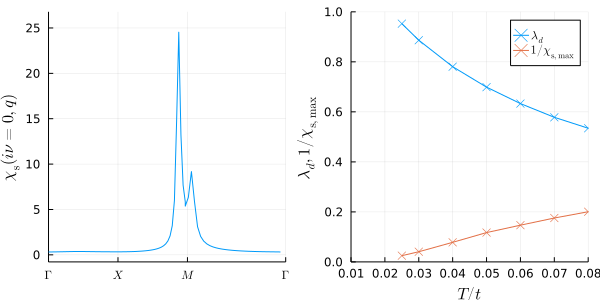

In [13]:
# first panel with momentum dependence of static spin susceptibility
chi_s_HSP= Array{Float64}(undef,Int64(3*(solver.mesh.nk1/2)))
for i in 1:Int64(solver.mesh.nk1/2)
    chi_s_HSP[i] = chi_s_plt[1,i]
    chi_s_HSP[Int64(solver.mesh.nk1/2)+i] = chi_s_plt[i,Int64(solver.mesh.nk1/2)+1]
    chi_s_HSP[solver.mesh.nk1+i] = chi_s_plt[Int64(solver.mesh.nk1/2)-i+2,Int64(solver.mesh.nk1/2)-i+2]
end

k_HSP= Array{Float64}(undef,Int64(3*(solver.mesh.nk1/2)))
for i in 1:solver.mesh.nk1
    k_HSP[i] = 2*(i-1)/nk1
end
for i in 1:Int64(solver.mesh.nk1/2)
    k_HSP[solver.mesh.nk1+i] = 2*(solver.mesh.nk1-1)/solver.mesh.nk1 + sqrt(2)*2*(i-1)/solver.mesh.nk1
end

plt3 = plot(k_HSP, chi_s_HSP,
xlim = (0,2+sqrt(2)), ylim = ([0,26]),label="",
xticks=(
    [0, 1, 2, 2+sqrt(2)],
    [latexstring("\\Gamma"),latexstring("X"),latexstring("M"),latexstring("\\Gamma")]),
ylabel = latexstring("\\chi_{\\mathrm{s}}(i\\nu=0,q)"))


Ones      = ones(Int,length(T_values))
# second panel with T-dependence of lambda_d and 1/chi_s,max
plt4 = plot(T_values, lam_T, markershape=:x, label=latexstring("\\lambda_d"),
    xlim=(0.01, 0.08), ylim=(0,1),size=(370,200),
    xlabel = latexstring("T/t"),
    ylabel = latexstring("\\lambda_d, 1/\\chi_{\\mathrm{s}, \\mathrm{max}}"))
plot!(plt4, T_values, Ones./chiSmax_T, markershape=:x, label=latexstring("1/\\chi_{\\mathrm{s},\\mathrm{max}}"))

plot(plt3, plt4, layout = (1,2), size=(600, 300))